# Import Libraries

In [ ]:
!python -m pip install gTTS

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from gtts import gTTS
from IPython.display import Audio
from tensorflow.keras.utils import plot_model

In [ ]:
import keras, tensorflow
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Bidirectional

In [ ]:
encoder_path='encoder_modelPredTranslation.h5'
decoder_path='decoder_modelPredTranslation.h5'
LOG_PATH="log"

# Loading Dataset

In [ ]:
train_t = pd.read_csv('/content/drive/MyDrive/Language_translation/english-french.csv',encoding= 'unicode_escape')

In [ ]:
df = train_t[0:10000]
df.head(10)

English words/sentences French words/sentences
0                     Hi.                 Salut!
1                    Run!                Cours !
2            Good morning                Bonjour
3                    Who?                  Qui ?
4                    Wow!             Ça alors !
5                   Fire!               Au feu !
6                   Help!             À l'aide !
7                   Jump.                 Saute.
8                   Stop!            Ça suffit !
9          Good afternoon       bonne après-midi

In [ ]:
len(df)

10000

In [ ]:
english_text = df['English words/sentences']
french_text = df['French words/sentences']

# Data Preprocessing

In [ ]:
import re
english = []
french = []
for i in range(len(english_text)):
    text = english_text[i].lower()
    text = re.sub('[^a-zA-Z]',' ',text)
    english.append(text)
    

for i in range(len(french_text)):
    ftext = french_text[i].lower()
    ftext = (re.sub("[^a-zA-Z']",' ',ftext))
    french.append("START_ " + ftext + " _END")

In [ ]:
english

['hi ',
 'run ',
 'good morning',
 'who ',
 'wow ',
 'fire ',
 'help ',
 'jump ',
 'stop ',
 'good afternoon',
 'stop ',
 'wait ',
 'wait ',
 'go on ',
 'go on ',
 'year',
 'hello ',
 'hello ',
 'i see ',
 'i try ',
 'i won ',
 'i won ',
 'i won ',
 'oh no ',
 'attack ',
 'attack ',
 'cheers ',
 'cheers ',
 'cheers ',
 'cheers ',
 'get up ',
 'go now ',
 'go now ',
 'go now ',
 'got it ',
 'got it ',
 'got it ',
 'got it ',
 'got it ',
 'hop in ',
 'hop in ',
 'hug me ',
 'hug me ',
 'i fell ',
 'i fell ',
 'i know ',
 'i left ',
 'i left ',
 'i lied ',
 'i lost ',
 'i paid ',
 'i m    ',
 'i m ok ',
 'i m ok ',
 'listen ',
 'no way ',
 'no way ',
 'no way ',
 'no way ',
 'no way ',
 'no way ',
 'no way ',
 'no way ',
 'no way ',
 'really ',
 'really ',
 'really ',
 'thanks ',
 'we try ',
 'we won ',
 'we won ',
 'we won ',
 'we won ',
 'ask tom ',
 'awesome ',
 'be calm ',
 'be calm ',
 'be calm ',
 'be cool ',
 'be fair ',
 'be fair ',
 'be fair ',
 'be fair ',
 'be fair ',
 'be fair

In [ ]:
#Vocabulary of English
all_eng_words = set()
for i in english:
    for j in i.split():
        all_eng_words.add(j)

#vocabulary of french
all_fre_words = set()
for i in french:
    for j in i.split():
        all_fre_words.add(j)

In [ ]:
#maxlen of the source sequence
max_length_src = 0
for i in english:
    a = len(i.split())
    if a>max_length_src:
        max_length_src = a
        
#maxlen of the target sequence
max_length_tar = 0
for j in french:
    b = len(j.split())
    if b>max_length_tar:
        max_length_tar = b

In [ ]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_fre_words))

# Calculate Vocab size for both source and targe
num_encoder_tokens = len(all_eng_words)
num_decoder_tokens = len(all_fre_words)

In [ ]:
#indexs for input and target sequences
input_index = dict([(words,i) for i,words in enumerate(input_words)])
target_index = dict([(word, i) for i, word in enumerate(target_words)])

#reverse index for input and target sequences
reverse_input_index = dict((i, word) for word, i in input_index.items())
reverse_target_index = dict((i, word) for word, i in target_index.items())

In [ ]:
input_index

{'a': 0,
 'abandon': 1,
 'aboard': 2,
 'about': 3,
 'above': 4,
 'absent': 5,
 'absurd': 6,
 'accept': 7,
 'ache': 8,
 'ached': 9,
 'aches': 10,
 'acquired': 11,
 'act': 12,
 'action': 13,
 'active': 14,
 'actor': 15,
 'adaptable': 16,
 'addicted': 17,
 'adjust': 18,
 'admire': 19,
 'admit': 20,
 'adopted': 21,
 'adorable': 22,
 'adore': 23,
 'adores': 24,
 'adult': 25,
 'adults': 26,
 'advice': 27,
 'afraid': 28,
 'after': 29,
 'afternoon': 30,
 'again': 31,
 'against': 32,
 'age': 33,
 'agent': 34,
 'agony': 35,
 'agree': 36,
 'agreed': 37,
 'agrees': 38,
 'ahead': 39,
 'aim': 40,
 'ain': 41,
 'air': 42,
 'alert': 43,
 'alive': 44,
 'all': 45,
 'allow': 46,
 'almonds': 47,
 'almost': 48,
 'alone': 49,
 'along': 50,
 'already': 51,
 'alright': 52,
 'also': 53,
 'always': 54,
 'am': 55,
 'amazed': 56,
 'amazing': 57,
 'ambitious': 58,
 'ambush': 59,
 'american': 60,
 'amnesia': 61,
 'amuse': 62,
 'amused': 63,
 'amusing': 64,
 'an': 65,
 'and': 66,
 'angel': 67,
 'angry': 68,
 'animals

In [ ]:
print(max_length_src)
print(max_length_tar)
print(num_encoder_tokens)
print(num_decoder_tokens)

5
13
2098
3765


# Vectorizing

In [ ]:
encoder_input_data = np.zeros(
    (len(df), max_length_src, num_encoder_tokens),
    dtype='float32')
decoder_input_data = np.zeros(
    (len(df), max_length_tar, num_decoder_tokens),
    dtype='float32')
decoder_target_data = np.zeros(
    (len(df), max_length_tar, num_decoder_tokens),
    dtype='float32')

In [ ]:
for j in range(10000):
    for i,text in enumerate(english[j].split()):
        encoder_input_data[j,i,input_index[text]] = 1
    encoder_input_data[j, i + 1:, input_index[text]] = 1

for j in range(10000):
    for i,text in enumerate(french[j].split()):
        decoder_input_data[j,i,target_index[text]] = 1
        if i>0:
            decoder_target_data[j,i-1,target_index[text]] = 1
    decoder_input_data[j, i + 1:, target_index[text]] = 1
    decoder_target_data[j, i:, target_index[text]] = 1

In [ ]:
latent_dim = 256
epochs= 50
batch_size = 64

# Encoder

In [ ]:
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

# Decoder

In [ ]:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences= True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                                     initial_state= encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Training of Model

In [ ]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#summary and model plot
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 2098)  0           []                               
                                ]                                                                 
                                                                                                  
 input_2 (InputLayer)           [(None, None, 3765)  0           []                               
                                ]                                                                 
                                                                                                  
 lstm (LSTM)                    [(None, 256),        2411520     ['input_1[0][0]']                
                                 (None, 256),                                                 

In [ ]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size= batch_size,
          epochs = epochs,
          validation_split=0.2)

Epoch 1/50
125/125 [==============================] - 13s 50ms/step - loss: 2.6598 - accuracy: 0.7292 - val_loss: 2.0053 - val_accuracy: 0.7139
Epoch 2/50
125/125 [==============================] - 5s 36ms/step - loss: 1.6974 - accuracy: 0.7484 - val_loss: 1.9307 - val_accuracy: 0.7182
Epoch 3/50
125/125 [==============================] - 5s 36ms/step - loss: 1.6078 - accuracy: 0.7545 - val_loss: 1.8837 - val_accuracy: 0.7248
Epoch 4/50
125/125 [==============================] - 5s 36ms/step - loss: 1.5001 - accuracy: 0.7664 - val_loss: 1.7986 - val_accuracy: 0.7400
Epoch 5/50
125/125 [==============================] - 5s 41ms/step - loss: 1.3999 - accuracy: 0.7787 - val_loss: 1.7329 - val_accuracy: 0.7505
Epoch 6/50
125/125 [==============================] - 5s 38ms/step - loss: 1.3039 - accuracy: 0.7893 - val_loss: 1.6710 - val_accuracy: 0.7587
Epoch 7/50
125/125 [==============================] - 5s 36ms/step - loss: 1.2154 - accuracy: 0.7976 - val_loss: 1.6187 - val_accuracy: 0.766

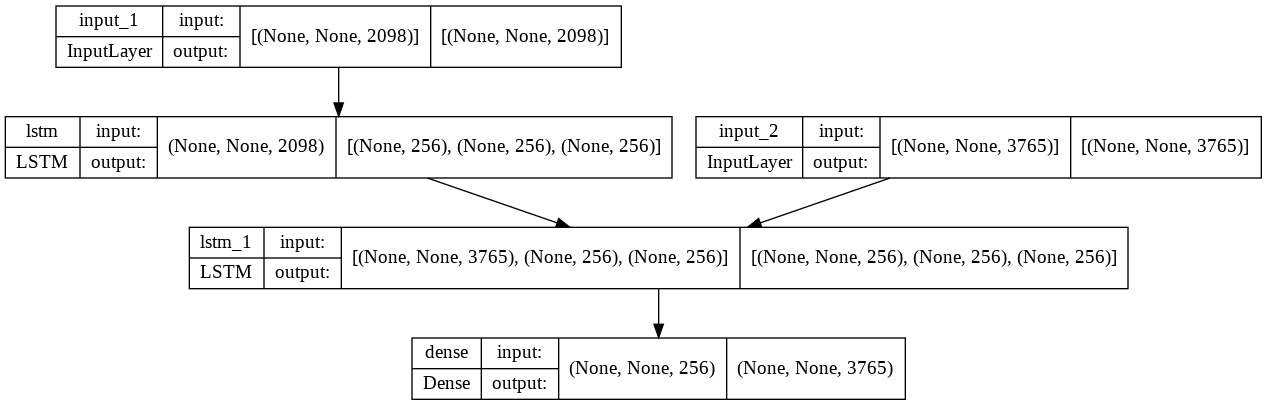

In [ ]:
plot_model(model, to_file='Model_plot.png', show_shapes=True, show_layer_names=True)

# Inference

In [ ]:
encoder_model.save(encoder_path)             #saving the encoder model
decoder_model.save(decoder_path)             # saving the decoder model

In [ ]:
encoder_model = Model(encoder_inputs,encoder_states)

decoder_state_h = Input(shape=(latent_dim,))
decoder_state_c = Input(shape=(latent_dim,))
decode_state = [decoder_state_h,decoder_state_c]

decoder_outputs,state_h,state_c = decoder_lstm(decoder_inputs,initial_state = decode_state)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model([decoder_inputs] + decode_state,[decoder_outputs] + decoder_states)

In [ ]:
def decode_sequence(input_seq):
    # encode the input sequence to get the internal state vectors.
    states_value = encoder_model.predict(input_seq)
  
    # generate empty target sequence of length 1 with only the start character
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    target_seq[0, 0, target_index['START_']] = 1.
  
    # output sequence loop
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)
    
        # sample a token and add the corresponding character to the 
        # decoded sequence
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_index[sampled_token_index]
        
        if (sampled_char == "_END" or len(decoded_sentence) > max_length_tar):
            stop_condition = True
            break
            
        decoded_sentence += sampled_char
        decoded_sentence +=' '
      
        # update the target sequence (length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.
    
        # update states
        states_value = [h, c]
    
    return decoded_sentence

In [ ]:
def saveChar2encoding(filename,input_token_index,max_encoder_seq_length,num_encoder_tokens,reverse_target_char_index,num_decoder_tokens,target_token_index):
    f = open(filename, "wb")
    pickle.dump(input_token_index, f)
    pickle.dump(max_encoder_seq_length, f)
    pickle.dump(num_encoder_tokens, f)
    pickle.dump(reverse_target_char_index, f)
    
    pickle.dump(num_decoder_tokens, f)
    
    pickle.dump(target_token_index, f)
    f.close()

In [ ]:
def getChar2encoding(filename):
    f = open(filename, "rb")
    input_token_index = pickle.load(f)
    max_encoder_seq_length = pickle.load(f)
    num_encoder_tokens = pickle.load(f)
    reverse_target_char_index = pickle.load(f)
    num_decoder_tokens = pickle.load(f)
    target_token_index = pickle.load(f)
    f.close()
    return input_token_index,max_encoder_seq_length,num_encoder_tokens,reverse_target_char_index,num_decoder_tokens,target_token_index

# Testing on Sentence & converting in Audio

In [ ]:
toks = [input("enter sentence :" )]
for t in toks:
    input_sentence = t.lower()
    test_sentence_tokenized = np.zeros((1, max_length_src, num_encoder_tokens), dtype='float32')
    for t, char in enumerate(input_sentence.split()):
        test_sentence_tokenized[0, t, input_index[char]] = 1.
    print("Input Sentence:", input_sentence)
    print("Decoded Sentence:", decode_sequence(test_sentence_tokenized))

tts1 = gTTS(decode_sequence(test_sentence_tokenized))
tts1.save('1.wav')
sound_file2 = '1.wav'
Audio(sound_file2, autoplay=True)

enter sentence :GOOD MORNING
Input Sentence: good morning
Decoded Sentence: bonjour 


In [ ]:
toks = [input("enter sentence :" )]
for t in toks:
    input_sentence = t.lower()
    test_sentence_tokenized = np.zeros((1, max_length_src, num_encoder_tokens), dtype='float32')
    for t, char in enumerate(input_sentence.split()):
        test_sentence_tokenized[0, t, input_index[char]] = 1.
    print("Input Sentence:", input_sentence)
    print("Decoded Sentence:", decode_sequence(test_sentence_tokenized))

tts1 = gTTS(decode_sequence(test_sentence_tokenized))
tts1.save('1.wav')
sound_file2 = '1.wav'
Audio(sound_file2, autoplay=True)

enter sentence :come quick
Input Sentence: come quick
Decoded Sentence: viens vite 


In [ ]:
toks = [input("enter sentence :" )]
for t in toks:
    input_sentence = t.lower()
    test_sentence_tokenized = np.zeros((1, max_length_src, num_encoder_tokens), dtype='float32')
    for t, char in enumerate(input_sentence.split()):
        test_sentence_tokenized[0, t, input_index[char]] = 1.
    print("Input Sentence:", input_sentence)
    print("Decoded Sentence:", decode_sequence(test_sentence_tokenized))

tts1 = gTTS(decode_sequence(test_sentence_tokenized))
tts1.save('1.wav')
sound_file2 = '1.wav'
Audio(sound_file2, autoplay=True)

enter sentence :i will try
Input Sentence: i will try
Decoded Sentence: je vais essayer 
